# P02_04_EDA

In [1]:
section_fig_main_title = 'P02_04_EDA_'

In [2]:
import os, sys
import requests
from urllib.parse import urljoin, urlparse
from bs4 import BeautifulSoup as bs
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pandas.plotting import lag_plot

In [3]:
from pandas.plotting import autocorrelation_plot


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [6]:
from sklearn import metrics
import statsmodels.api as sm

## Read Data


In [7]:
csv_path = "../Data/Data_ICME_Edited_Decoded_out_P02_03.csv"
df = pd.read_csv(csv_path, parse_dates=True, infer_datetime_format=True)

In [8]:
df.head(2)

,ICME Plasma/Field Start Y/M/D (UT) (b),ICME Plasma/Field End Y/M/D (UT) (b),BDE? (e),Qual. (g),dV (km/s) (h),V_ICME (km/s) (i),V_max (km/s) (j),B (nT) (k),MC? (l),Dst (nT) (m),Normalized_time_interval
0,1996-05-27 15:00:00,1996-05-29 03:00:00,1,2,1,370,400,9,3,117,1.375000
1,1996-07-01 18:00:00,1996-07-02 11:00:00,1,4,44,360,370,11,3,78,0.583333


In [9]:
df.corr().T

,BDE? (e),Qual. (g),dV (km/s) (h),V_ICME (km/s) (i),V_max (km/s) (j),B (nT) (k),MC? (l),Dst (nT) (m),Normalized_time_interval
BDE? (e),1.000000,-0.144482,0.067712,0.187825,0.190846,0.207502,0.130491,-0.003364,0.100129
Qual. (g),-0.144482,1.000000,-0.093310,-0.121396,-0.147253,-0.320273,-0.341033,-0.019219,-0.122643
dV (km/s) (h),0.067712,-0.093310,1.000000,0.074620,0.105924,0.169528,0.136470,0.052603,-0.011099
V_ICME (km/s) (i),0.187825,-0.121396,0.074620,1.000000,0.922499,0.228757,-0.062064,0.115497,0.027208
V_max (km/s) (j),0.190846,-0.147253,0.105924,0.922499,1.000000,0.176905,-0.050903,0.090592,0.217007
B (nT) (k),0.207502,-0.320273,0.169528,0.228757,0.176905,1.000000,0.429072,0.031962,-0.128620
MC? (l),0.130491,-0.341033,0.136470,-0.062064,-0.050903,0.429072,1.000000,-0.009065,0.011706
Dst (nT) (m),-0.003364,-0.019219,0.052603,0.115497,0.090592,0.031962,-0.009065,1.000000,-0.081116
Normalized_time_interval,0.100129,-0.122643,-0.011099,0.027208,0.217007,-0.128620,0.011706,-0.081116,1.000000


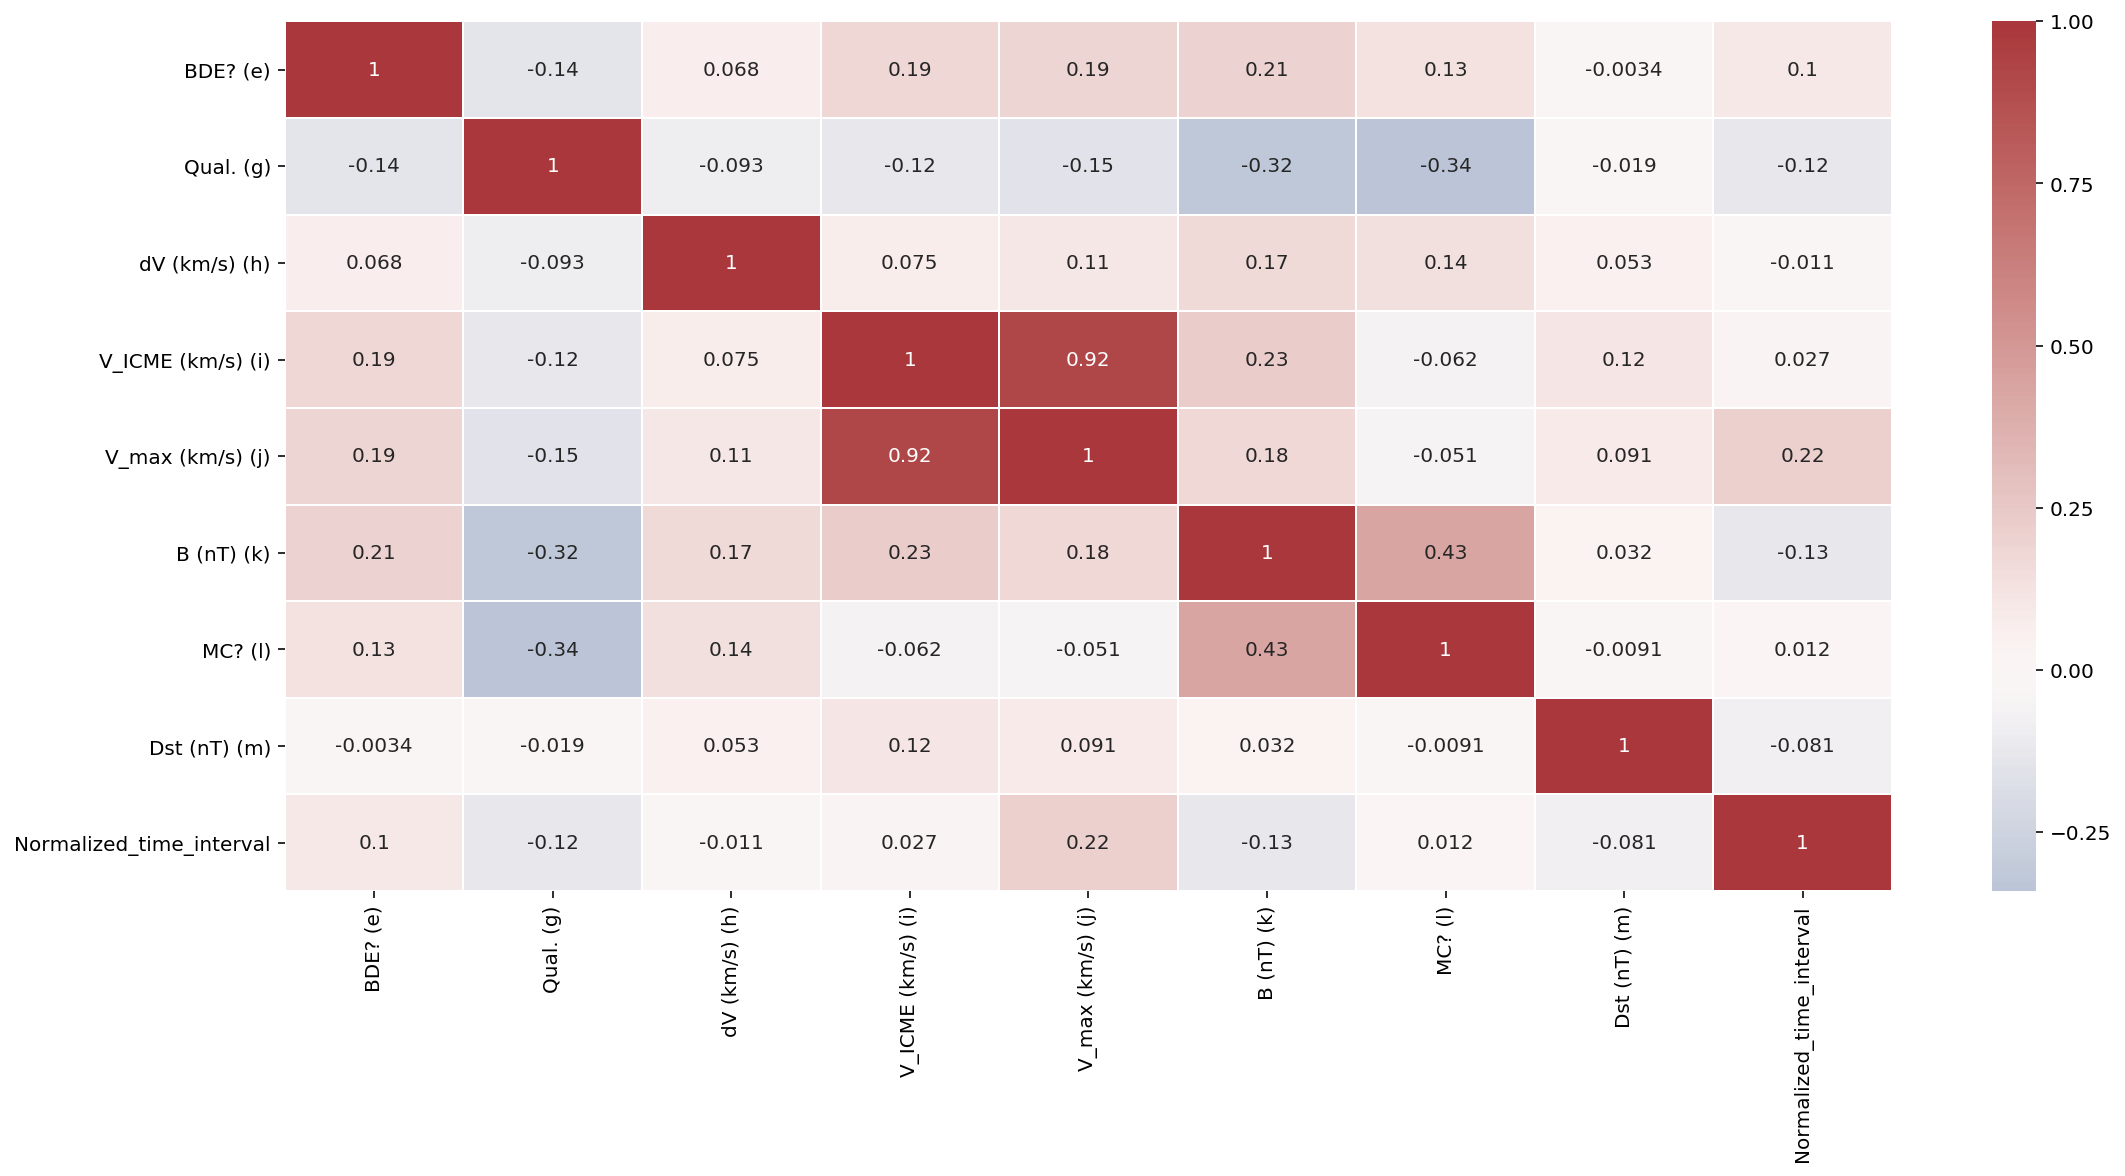

In [10]:
df_corr = df.corr()
plt.figure(figsize=(18,8))

sns.heatmap(df_corr, 
            xticklabels=df_corr.columns,
            yticklabels=df_corr.columns,
            cmap='vlag',
            annot=True,
            linewidth=0.5, center=0,
            #vmin=-0.07, vmax=0.07
           )
plt.savefig("../Figures/" + section_fig_main_title +"corr.png")

a covariance between two columns is observed. ```V_ICME (km/s) (i), V_max (km/s) (j)```

motivated by the dimensionality reduction concept, choose one as a target and drop the other one.

Let's drop ```V_ICME (km/s) (i)``` columns and go with other one. nevertheless, one can choose the other one.

In [11]:
df = df.drop(columns=['V_ICME (km/s) (i)'])

In [12]:
df.head()

,ICME Plasma/Field Start Y/M/D (UT) (b),ICME Plasma/Field End Y/M/D (UT) (b),BDE? (e),Qual. (g),dV (km/s) (h),V_max (km/s) (j),B (nT) (k),MC? (l),Dst (nT) (m),Normalized_time_interval
0,1996-05-27 15:00:00,1996-05-29 03:00:00,1,2,1,400,9,3,117,1.375000
1,1996-07-01 18:00:00,1996-07-02 11:00:00,1,4,44,370,11,3,78,0.583333
2,1996-08-07 12:00:00,1996-08-08 10:00:00,1,2,2,380,7,3,88,0.791667
3,1996-12-23 17:00:00,1996-12-25 11:00:00,1,2,22,420,10,3,69,1.625000
4,1997-01-10 04:00:00,1997-01-11 02:00:00,3,1,4,460,14,3,191,0.791667


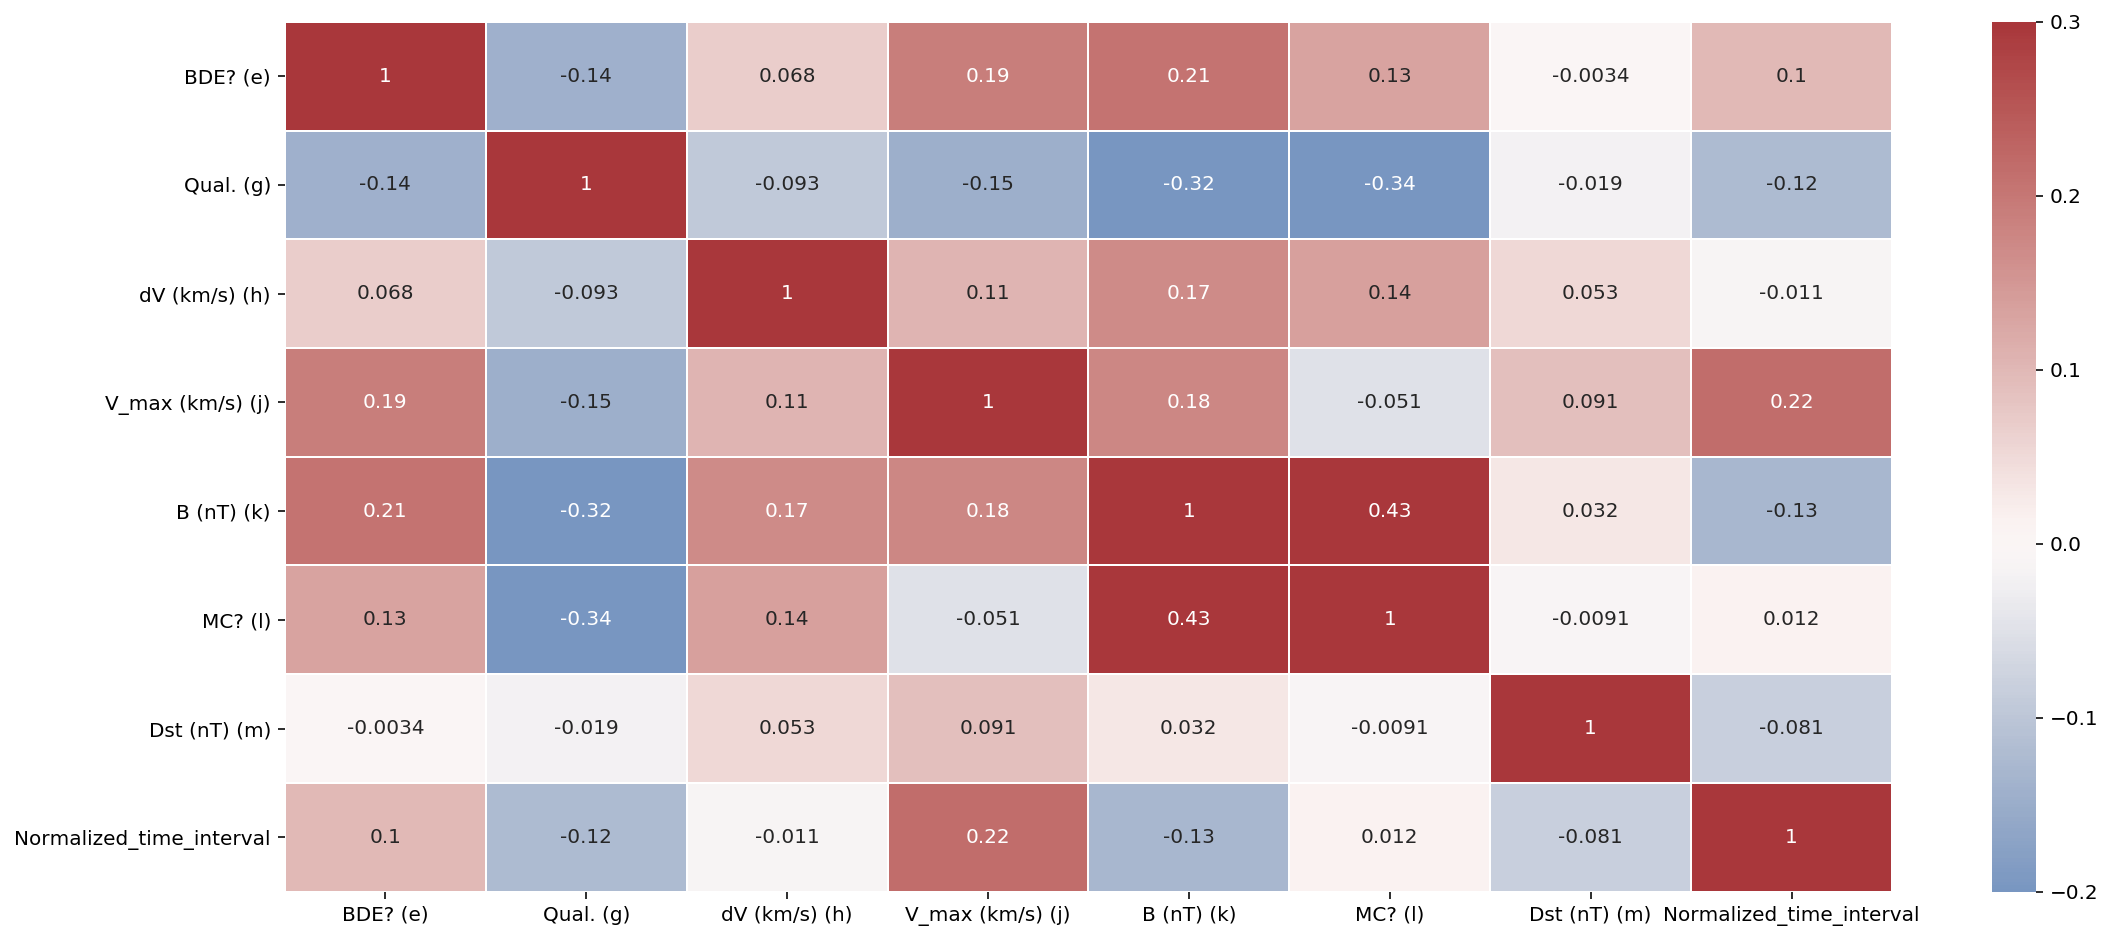

In [13]:
df_corr = df.corr()
plt.figure(figsize=(18,8))

sns.heatmap(df_corr, 
            xticklabels=df_corr.columns,
            yticklabels=df_corr.columns,
            cmap='vlag',
            annot=True,
            linewidth=0.5, center=0,
            vmin=-0.2, vmax=0.3
           )
plt.savefig("../Figures/" + section_fig_main_title +"corr_2.png")

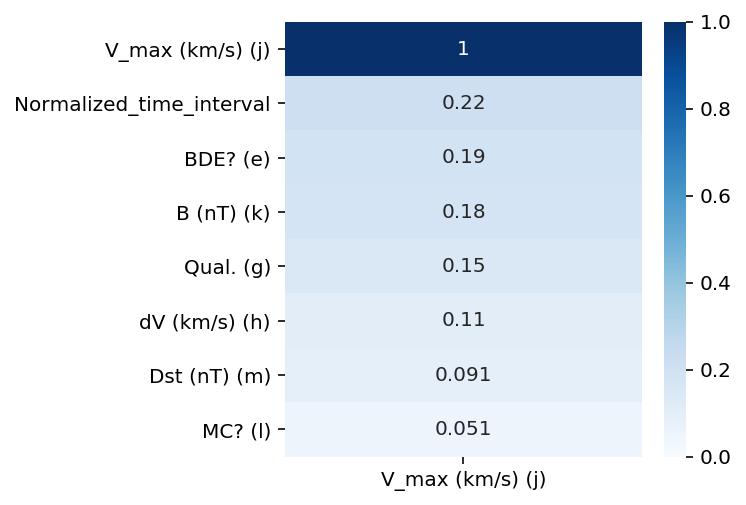

In [14]:
df_corr = df.corr().abs()
plt.figure(figsize=(4,4))
sns.heatmap(df_corr[['V_max (km/s) (j)']].sort_values(by=['V_max (km/s) (j)'],ascending=False),
            vmin=0,
            cmap='Blues',
            annot=True);
plt.savefig("../Figures/" + section_fig_main_title +"corr_3.png")
plt.show()

In [15]:
df.columns

Index(['ICME Plasma/Field Start Y/M/D (UT) (b)',
       'ICME Plasma/Field End Y/M/D (UT) (b)', 'BDE? (e)', 'Qual. (g)',
       'dV (km/s) (h)', 'V_max (km/s) (j)', 'B (nT) (k)', 'MC? (l)',
       'Dst (nT) (m)', 'Normalized_time_interval'],
      dtype='object')

In [16]:
X = df[['BDE? (e)', 'Qual. (g)','dV (km/s) (h)', 
        'B (nT) (k)', 'MC? (l)','Dst (nT) (m)', 
        'Normalized_time_interval']]

y = df['V_max (km/s) (j)']

In [17]:
lr = LinearRegression()

lr.fit(X, y)
y_pred = lr.predict(X)

In [18]:
score = lr.score(X, y)
MAE = metrics.mean_absolute_error(y, y_pred)

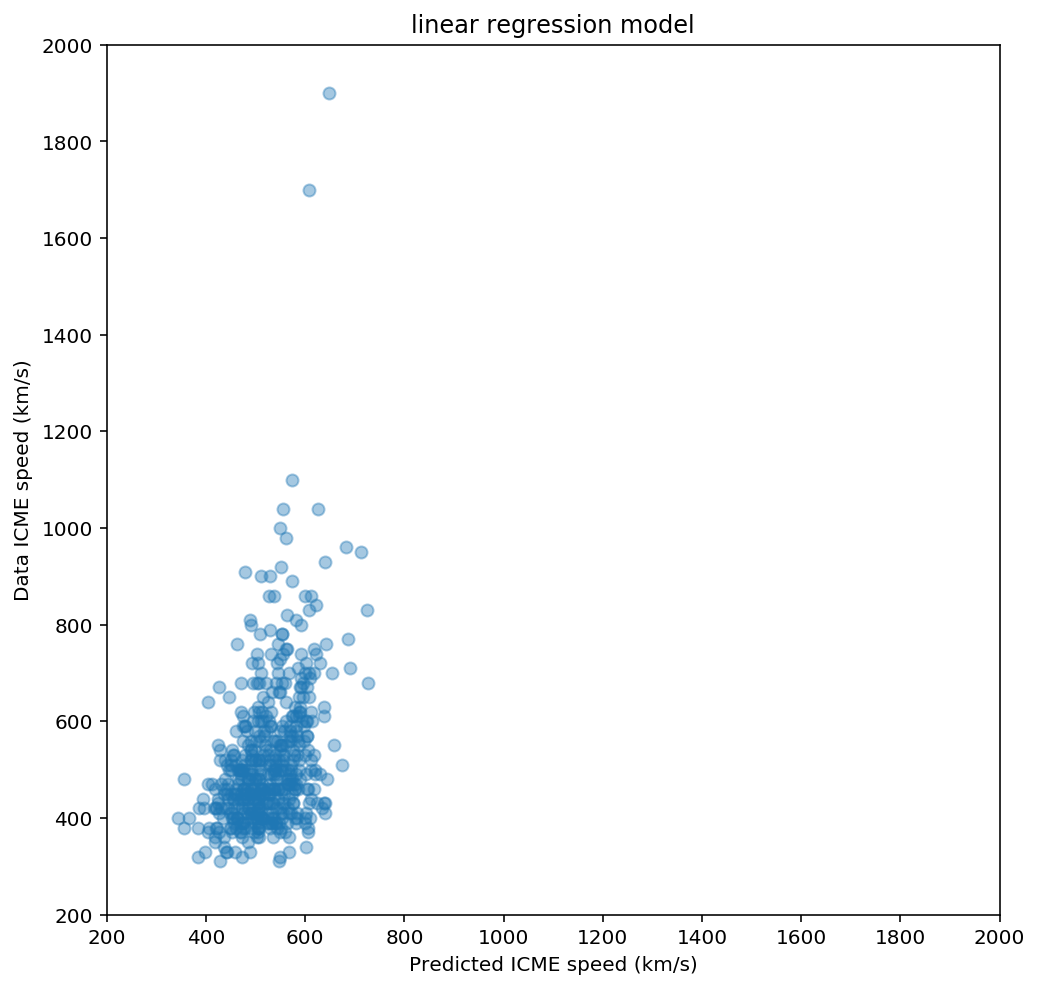

In [19]:
plt.rcParams["figure.figsize"] = (8, 8)
plt.scatter(y_pred, y, alpha=0.4)
plt.xlabel("Predicted ICME speed (km/s)")
plt.ylabel("Data ICME speed (km/s)")
plt.title("linear regression model")
plt.xlim(200,2000)
plt.ylim(200,2000)
plt.savefig("../Figures/" + section_fig_main_title +"lr_1.png")

plt.show()

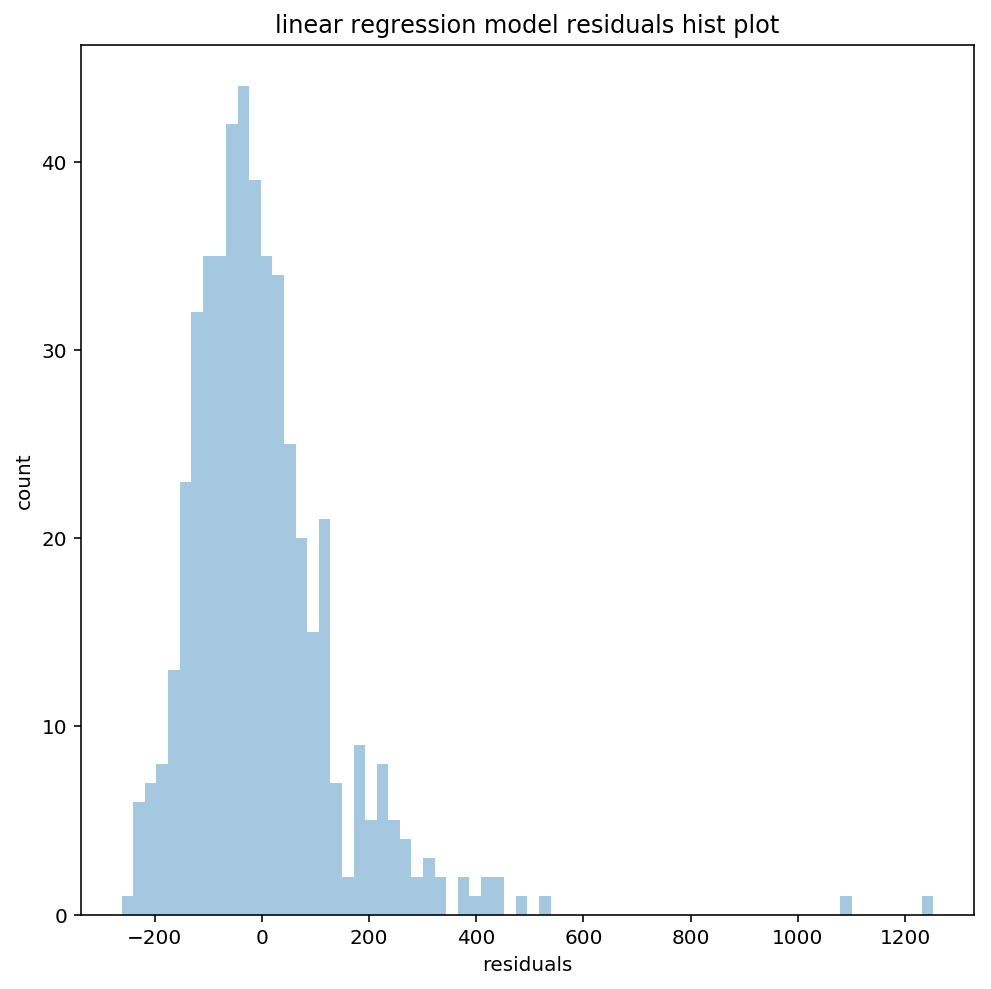

In [20]:
# Creat residuals
resids = y - y_pred
# N assumption:
plt.hist(resids, bins=70, alpha=0.4);
plt.xlabel("residuals")
plt.ylabel("count")
plt.title("linear regression model residuals hist plot")
plt.savefig("../Figures/" + section_fig_main_title +"lr_residu_1.png")

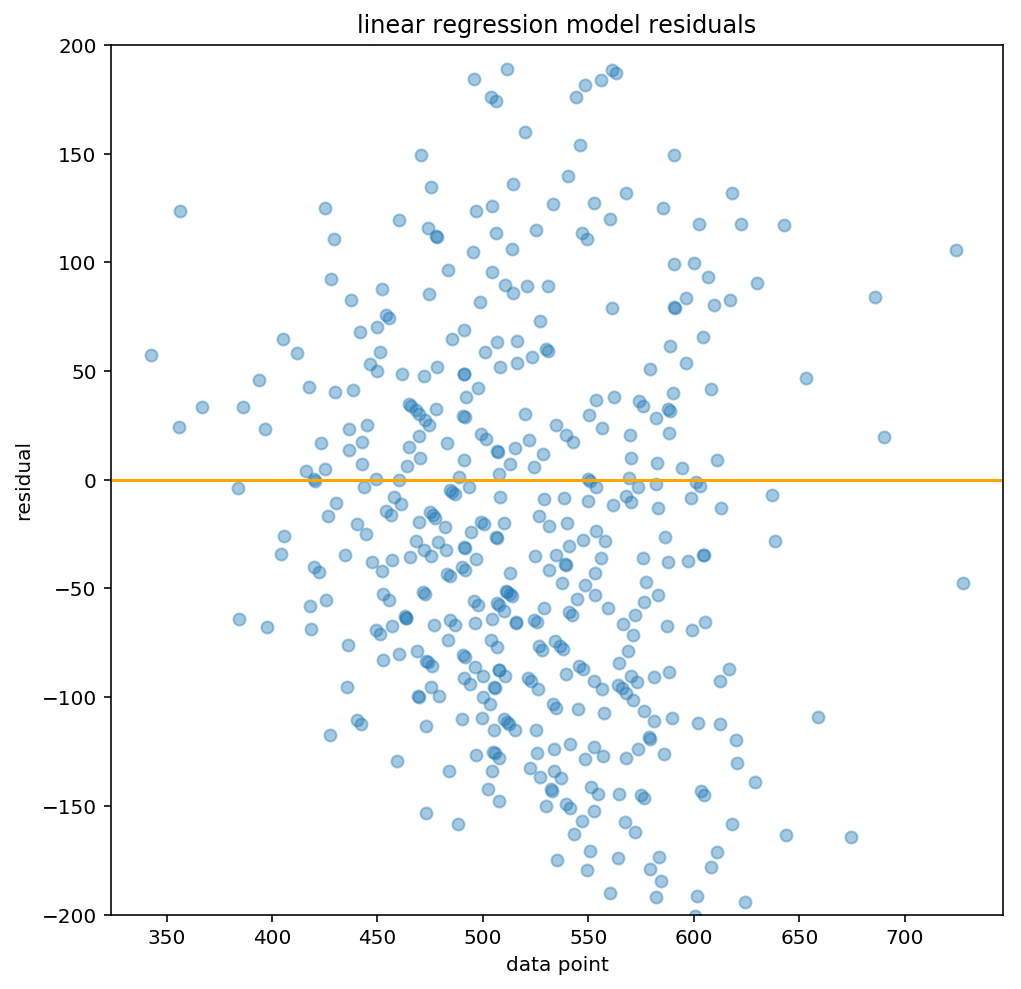

In [21]:
plt.scatter(y_pred, resids, alpha=0.4)
plt.axhline(0, color='orange');
plt.xlabel("data point")
plt.ylabel("residual")
# plt.xlim(0,)
plt.ylim(-200,200)
plt.title("linear regression model residuals")
plt.savefig("../Figures/" + section_fig_main_title +"lr_residu_1.png")

In [23]:
X_sm = sm.add_constant(X)
ols = sm.OLS(y, X_sm).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       V_max (km/s) (j)   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     12.75
Date:                Sun, 24 Oct 2021   Prob (F-statistic):           4.57e-15
Time:                        23:55:56   Log-Likelihood:                -3155.6
No. Observations:                 493   AIC:                             6327.
Df Residuals:                     485   BIC:                             6361.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      393.7378     39.870      9.876      0.000     315.399     472.077
BDE? (e)                    22.6466      7.501      3.019      0.003       7.909      37.384
Qual. (g)                  -11.7576      6.031     -1.949      0.052     -23.608       0.093
dV (km/s) (h)                0.6016      0.334      1.801      0.072      -0.055       1.258
B (nT) (k)                   8.1914      1.793      4.569      0.000       4.669      11.714
MC? (l)                    -38.1840      8.809     -4.335      0.000     -55.492     -20.876
Dst (nT) (m)                 0.2508      0.111      2.267      0.024       0.033       0.468
Normalized_time_interval    59.2099     10.989      5.388      0.000      37.617      80.802
==============================================================================
Omnibus:                      343.367   Durbin-Watson:                   1.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6564.431
Skew:                           2.753   Prob(JB):                         0.00
Kurtosis:                      20.007   Cond. No.                         819.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

the features with p-values above 5% are not reliable. Simply more data is needed to come up with conclusive independent parameters.

## Engineering new feature.

In [24]:
df.columns

Index(['ICME Plasma/Field Start Y/M/D (UT) (b)',
       'ICME Plasma/Field End Y/M/D (UT) (b)', 'BDE? (e)', 'Qual. (g)',
       'dV (km/s) (h)', 'V_max (km/s) (j)', 'B (nT) (k)', 'MC? (l)',
       'Dst (nT) (m)', 'Normalized_time_interval'],
      dtype='object')

In [25]:
# df['Nor_BDE*'] = df['Normalized_time_interval']*df['BDE? (e)']

In [26]:
# df['Nor_BnT*'] = df['Normalized_time_interval']*df['B (nT) (k)']

In [27]:
# df['Nor_Qual*'] = df['Normalized_time_interval']*df['Qual. (g)']

In [28]:
# df['Nor_BDE_BnT*'] = df['Normalized_time_interval']*df['B (nT) (k)']*df['BDE? (e)']

In [29]:
col_1_list = [ 'BDE? (e)', 'Qual. (g)','dV (km/s) (h)', 
               'B (nT) (k)', 'MC? (l)',
               'Dst (nT) (m)', 'Normalized_time_interval']

col_2_list = col_1_list

In [30]:
# binary combinations

for col1 in col_1_list:
    for col2 in col_2_list:
#         print(col1)
        if col1 == col2:
            pass
        else:
            
            new_col_name = col1 + '*' + col2 + '**'
    #         col11 = col1.replace(' ','_')
    #         col22 = col2.replace(' ','_')
            df[new_col_name] = df[col1]*df[col2]


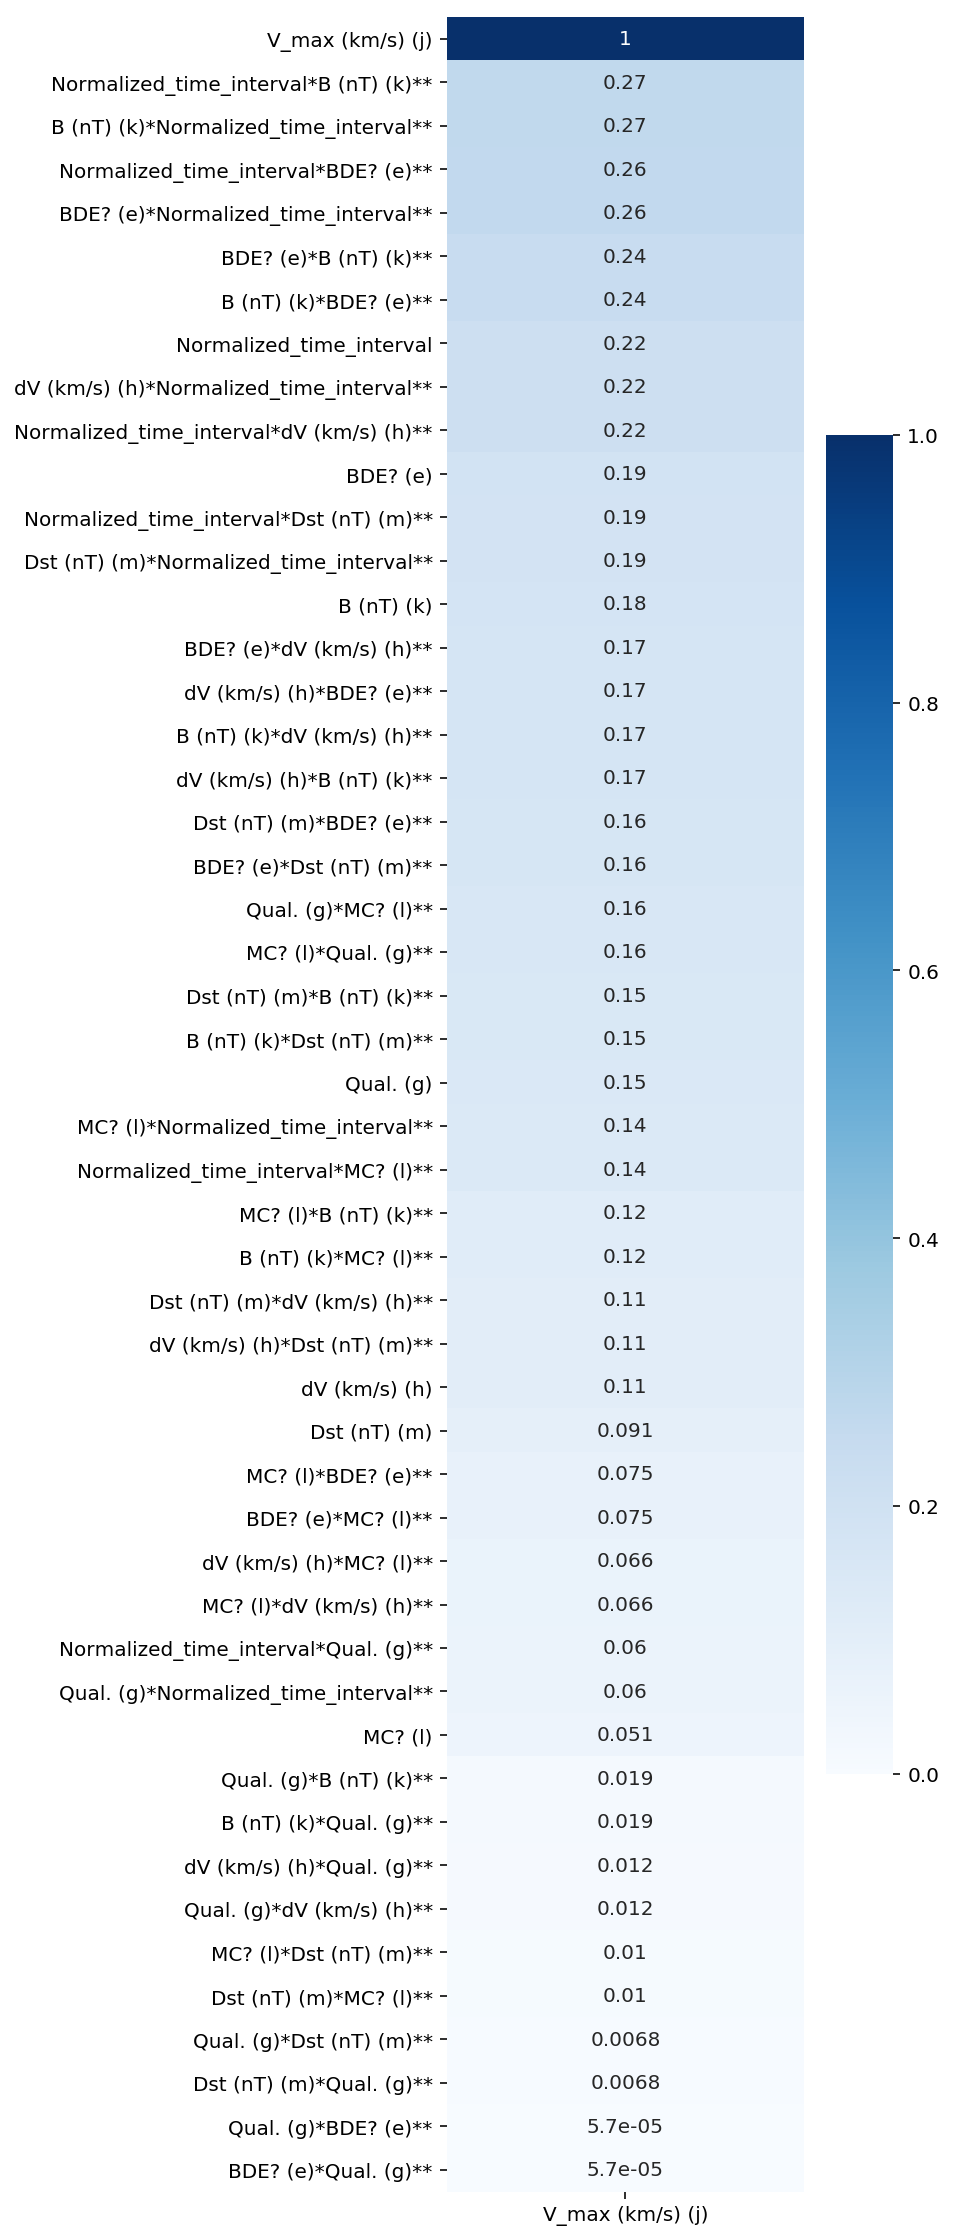

In [31]:
df_corr = df.corr().abs()
plt.figure(figsize=(4,20))
sns.heatmap(df_corr[['V_max (km/s) (j)']].sort_values(by=['V_max (km/s) (j)'],ascending=False),
            vmin=0,
            cmap='Blues',
            annot=True);
plt.savefig("../Figures/" + section_fig_main_title +"engin_feature_ord2.png")
plt.show()

In [32]:
df_cor_index = (df_corr[['V_max (km/s) (j)']].sort_values(by=['V_max (km/s) (j)'],ascending=False))
df_cor_index.index

Index(['V_max (km/s) (j)', 'Normalized_time_interval*B (nT) (k)**',
       'B (nT) (k)*Normalized_time_interval**',
       'Normalized_time_interval*BDE? (e)**',
       'BDE? (e)*Normalized_time_interval**', 'BDE? (e)*B (nT) (k)**',
       'B (nT) (k)*BDE? (e)**', 'Normalized_time_interval',
       'dV (km/s) (h)*Normalized_time_interval**',
       'Normalized_time_interval*dV (km/s) (h)**', 'BDE? (e)',
       'Normalized_time_interval*Dst (nT) (m)**',
       'Dst (nT) (m)*Normalized_time_interval**', 'B (nT) (k)',
       'BDE? (e)*dV (km/s) (h)**', 'dV (km/s) (h)*BDE? (e)**',
       'B (nT) (k)*dV (km/s) (h)**', 'dV (km/s) (h)*B (nT) (k)**',
       'Dst (nT) (m)*BDE? (e)**', 'BDE? (e)*Dst (nT) (m)**',
       'Qual. (g)*MC? (l)**', 'MC? (l)*Qual. (g)**',
       'Dst (nT) (m)*B (nT) (k)**', 'B (nT) (k)*Dst (nT) (m)**', 'Qual. (g)',
       'MC? (l)*Normalized_time_interval**',
       'Normalized_time_interval*MC? (l)**', 'MC? (l)*B (nT) (k)**',
       'B (nT) (k)*MC? (l)**', 'Dst (nT) (m

In [33]:
len(df_cor_index)

50

In [34]:
df_cor_index

,V_max (km/s) (j)
V_max (km/s) (j),1.000000
Normalized_time_interval*B (nT) (k)**,0.266275
B (nT) (k)*Normalized_time_interval**,0.266275
Normalized_time_interval*BDE? (e)**,0.264769
BDE? (e)*Normalized_time_interval**,0.264769
BDE? (e)*B (nT) (k)**,0.240390
B (nT) (k)*BDE? (e)**,0.240390
Normalized_time_interval,0.217007
dV (km/s) (h)*Normalized_time_interval**,0.216895
Normalized_time_interval*dV (km/s) (h)**,0.216895



```
col_names = ['V_max (km/s) (j)', 
             
             'Normalized_time_interval*B (nT) (k)**', 'B (nT) (k)*Normalized_time_interval**',
           'Normalized_time_interval*BDE? (e)**','BDE? (e)*Normalized_time_interval**', 
             
             'BDE? (e)*B (nT) (k)**',
           'B (nT) (k)*BDE? (e)**', 
             
             'Normalized_time_interval',
             
           'dV (km/s) (h)*Normalized_time_interval**',
           'Normalized_time_interval*dV (km/s) (h)**', 
             
             'BDE? (e)',
             
           'Normalized_time_interval*Dst (nT) (m)**',
           'Dst (nT) (m)*Normalized_time_interval**', 
             
             'B (nT) (k)',
             
           'BDE? (e)*dV (km/s) (h)**', 'dV (km/s) (h)*BDE? (e)**',
             
           'B (nT) (k)*dV (km/s) (h)**', 'dV (km/s) (h)*B (nT) (k)**',
             
           'Dst (nT) (m)*BDE? (e)**', 'BDE? (e)*Dst (nT) (m)**',
             
           'Qual. (g)*MC? (l)**', 'MC? (l)*Qual. (g)**',
             
           'Dst (nT) (m)*B (nT) (k)**', 'B (nT) (k)*Dst (nT) (m)**', 
             
             'Qual. (g)',
             
           'MC? (l)*Normalized_time_interval**','Normalized_time_interval*MC? (l)**', 
             'MC? (l)*B (nT) (k)**','B (nT) (k)*MC? (l)**', 
             
             'Dst (nT) (m)*dV (km/s) (h)**','dV (km/s) (h)*Dst (nT) (m)**', 
             
             'dV (km/s) (h)', 
             
             'Dst (nT) (m)',
             
           'MC? (l)*BDE? (e)**', 'BDE? (e)*MC? (l)**', 
             
             'dV (km/s) (h)*MC? (l)**','MC? (l)*dV (km/s) (h)**', 
             
             'Normalized_time_interval*Qual. (g)**','Qual. (g)*Normalized_time_interval**', 
             
             'MC? (l)',
             
           'Qual. (g)*B (nT) (k)**', 'B (nT) (k)*Qual. (g)**',
             
           'dV (km/s) (h)*Qual. (g)**', 'Qual. (g)*dV (km/s) (h)**',
             
           'MC? (l)*Dst (nT) (m)**', 'Dst (nT) (m)*MC? (l)**',
             
           'Qual. (g)*Dst (nT) (m)**', 'Dst (nT) (m)*Qual. (g)**',
             
           'Qual. (g)*BDE? (e)**', 'BDE? (e)*Qual. (g)**']
```

In [35]:
keep_cols = ['V_max (km/s) (j)', 
             'Normalized_time_interval*B (nT) (k)**',
           'Normalized_time_interval*BDE? (e)**',
             
             'BDE? (e)*B (nT) (k)**',
             
             'Normalized_time_interval',
             
           'dV (km/s) (h)*Normalized_time_interval**',
             
             'BDE? (e)',
             
           'Normalized_time_interval*Dst (nT) (m)**',
             
             'B (nT) (k)',
             
           'BDE? (e)*dV (km/s) (h)**',
             
           'B (nT) (k)*dV (km/s) (h)**', 
             
           'Dst (nT) (m)*BDE? (e)**', 
             
           'Qual. (g)*MC? (l)**', 
             
           'Dst (nT) (m)*B (nT) (k)**', 
             
             'Qual. (g)',
             
           'MC? (l)*Normalized_time_interval**', 
             'MC? (l)*B (nT) (k)**',
             
             'Dst (nT) (m)*dV (km/s) (h)**',
             
             'dV (km/s) (h)', 
             
             'Dst (nT) (m)',
             
           'MC? (l)*BDE? (e)**', 
             
             'dV (km/s) (h)*MC? (l)**',
             
             'Normalized_time_interval*Qual. (g)**',
             
             'MC? (l)',
             
           'Qual. (g)*B (nT) (k)**', 
             
           'dV (km/s) (h)*Qual. (g)**',
             
           'MC? (l)*Dst (nT) (m)**', 
             
           'Qual. (g)*Dst (nT) (m)**', 
             
           'Qual. (g)*BDE? (e)**' ]

In [36]:
df_new = df[keep_cols]
df_new.head()

,V_max (km/s) (j),Normalized_time_interval*B (nT) (k)**,Normalized_time_interval*BDE? (e)**,BDE? (e)*B (nT) (k)**,Normalized_time_interval,dV (km/s) (h)*Normalized_time_interval**,BDE? (e),Normalized_time_interval*Dst (nT) (m)**,B (nT) (k),BDE? (e)*dV (km/s) (h)**,...,Dst (nT) (m),MC? (l)*BDE? (e)**,dV (km/s) (h)*MC? (l)**,Normalized_time_interval*Qual. (g)**,MC? (l),Qual. (g)*B (nT) (k)**,dV (km/s) (h)*Qual. (g)**,MC? (l)*Dst (nT) (m)**,Qual. (g)*Dst (nT) (m)**,Qual. (g)*BDE? (e)**
0,400,12.375000,1.375000,9,1.375000,1.375000,1,160.875000,9,1,...,117,3,3,2.750000,3,18,2,351,234,2
1,370,6.416667,0.583333,11,0.583333,25.666667,1,45.500000,11,44,...,78,3,132,2.333333,3,44,176,234,312,4
2,380,5.541667,0.791667,7,0.791667,1.583333,1,69.666667,7,2,...,88,3,6,1.583333,3,14,4,264,176,2
3,420,16.250000,1.625000,10,1.625000,35.750000,1,112.125000,10,22,...,69,3,66,3.250000,3,20,44,207,138,2
4,460,11.083333,2.375000,42,0.791667,3.166667,3,151.208333,14,12,...,191,9,12,0.791667,3,14,4,573,191,3


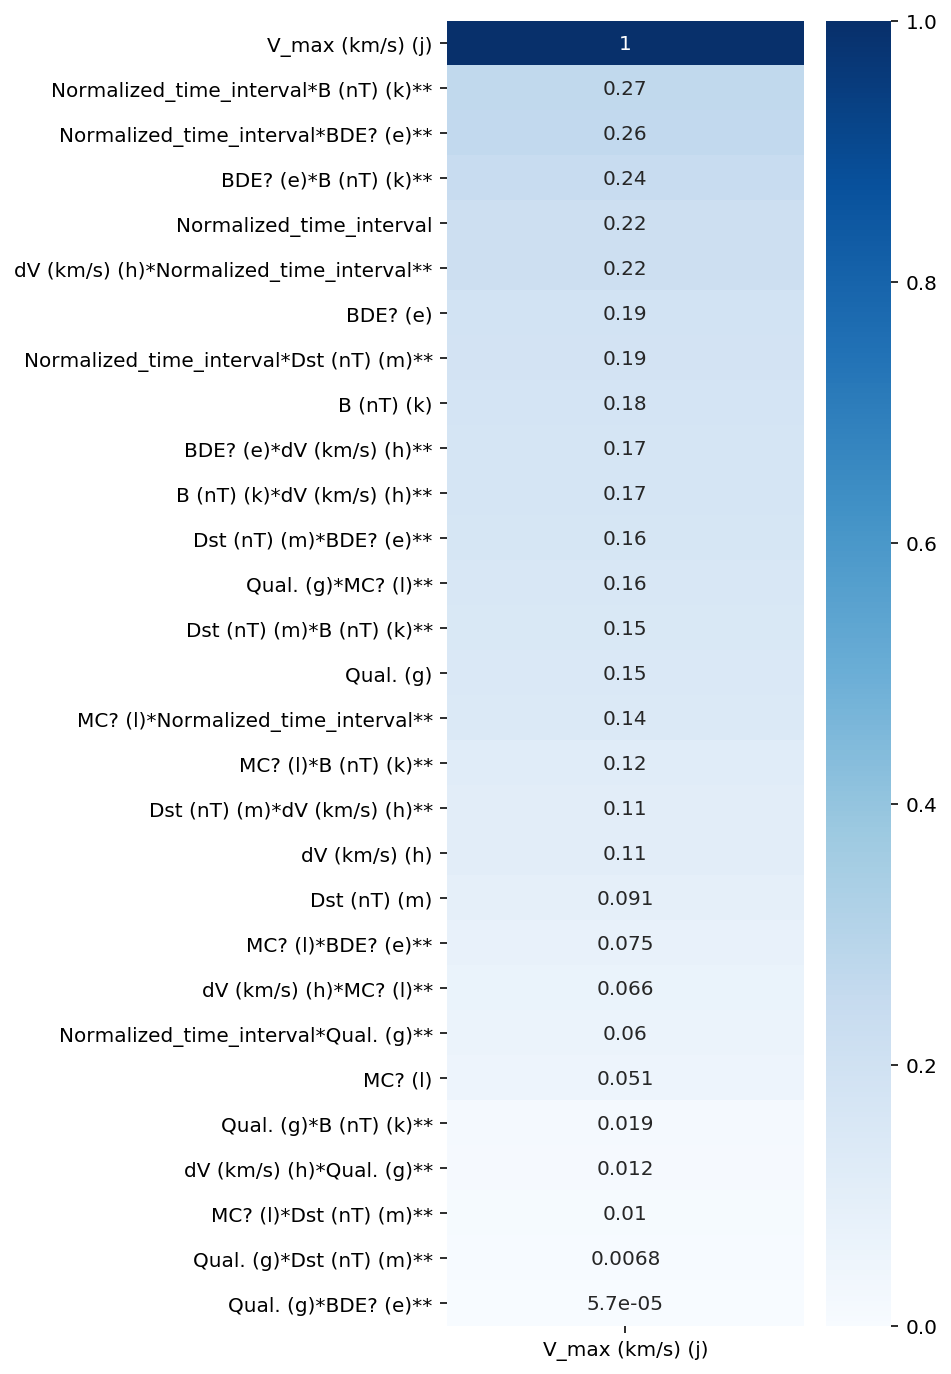

In [37]:
df_corr = df_new.corr().abs()
plt.figure(figsize=(4,12))
sns.heatmap(df_corr[['V_max (km/s) (j)']].sort_values(by=['V_max (km/s) (j)'],ascending=False),
            vmin=0,
            cmap='Blues',
            annot=True);
# plt.savefig("../Figures/" + section_fig_main_title +"new_df_engin_feature_ord2.png")
plt.show()

In [38]:
df_cor_index = (df_corr[['V_max (km/s) (j)']].sort_values(by=['V_max (km/s) (j)'],ascending=False))
df_cor_index.index

Index(['V_max (km/s) (j)', 'Normalized_time_interval*B (nT) (k)**',
       'Normalized_time_interval*BDE? (e)**', 'BDE? (e)*B (nT) (k)**',
       'Normalized_time_interval', 'dV (km/s) (h)*Normalized_time_interval**',
       'BDE? (e)', 'Normalized_time_interval*Dst (nT) (m)**', 'B (nT) (k)',
       'BDE? (e)*dV (km/s) (h)**', 'B (nT) (k)*dV (km/s) (h)**',
       'Dst (nT) (m)*BDE? (e)**', 'Qual. (g)*MC? (l)**',
       'Dst (nT) (m)*B (nT) (k)**', 'Qual. (g)',
       'MC? (l)*Normalized_time_interval**', 'MC? (l)*B (nT) (k)**',
       'Dst (nT) (m)*dV (km/s) (h)**', 'dV (km/s) (h)', 'Dst (nT) (m)',
       'MC? (l)*BDE? (e)**', 'dV (km/s) (h)*MC? (l)**',
       'Normalized_time_interval*Qual. (g)**', 'MC? (l)',
       'Qual. (g)*B (nT) (k)**', 'dV (km/s) (h)*Qual. (g)**',
       'MC? (l)*Dst (nT) (m)**', 'Qual. (g)*Dst (nT) (m)**',
       'Qual. (g)*BDE? (e)**'],
      dtype='object')

keep 8 top features

In [39]:
keep_cols = df_cor_index.index[0:8]

In [40]:
keep_cols

Index(['V_max (km/s) (j)', 'Normalized_time_interval*B (nT) (k)**',
       'Normalized_time_interval*BDE? (e)**', 'BDE? (e)*B (nT) (k)**',
       'Normalized_time_interval', 'dV (km/s) (h)*Normalized_time_interval**',
       'BDE? (e)', 'Normalized_time_interval*Dst (nT) (m)**'],
      dtype='object')

In [41]:
keep_cols = ['ICME Plasma/Field Start Y/M/D (UT) (b)','ICME Plasma/Field End Y/M/D (UT) (b)',
             'V_max (km/s) (j)', 'Normalized_time_interval*B (nT) (k)**',
           'Normalized_time_interval*BDE? (e)**', 'BDE? (e)*B (nT) (k)**',
           'Normalized_time_interval', 'dV (km/s) (h)*Normalized_time_interval**',
           'BDE? (e)', 'Normalized_time_interval*Dst (nT) (m)**']

In [42]:
df_new_2 = df[keep_cols]
df_new_2.head()

,ICME Plasma/Field Start Y/M/D (UT) (b),ICME Plasma/Field End Y/M/D (UT) (b),V_max (km/s) (j),Normalized_time_interval*B (nT) (k)**,Normalized_time_interval*BDE? (e)**,BDE? (e)*B (nT) (k)**,Normalized_time_interval,dV (km/s) (h)*Normalized_time_interval**,BDE? (e),Normalized_time_interval*Dst (nT) (m)**
0,1996-05-27 15:00:00,1996-05-29 03:00:00,400,12.375000,1.375000,9,1.375000,1.375000,1,160.875000
1,1996-07-01 18:00:00,1996-07-02 11:00:00,370,6.416667,0.583333,11,0.583333,25.666667,1,45.500000
2,1996-08-07 12:00:00,1996-08-08 10:00:00,380,5.541667,0.791667,7,0.791667,1.583333,1,69.666667
3,1996-12-23 17:00:00,1996-12-25 11:00:00,420,16.250000,1.625000,10,1.625000,35.750000,1,112.125000
4,1997-01-10 04:00:00,1997-01-11 02:00:00,460,11.083333,2.375000,42,0.791667,3.166667,3,151.208333


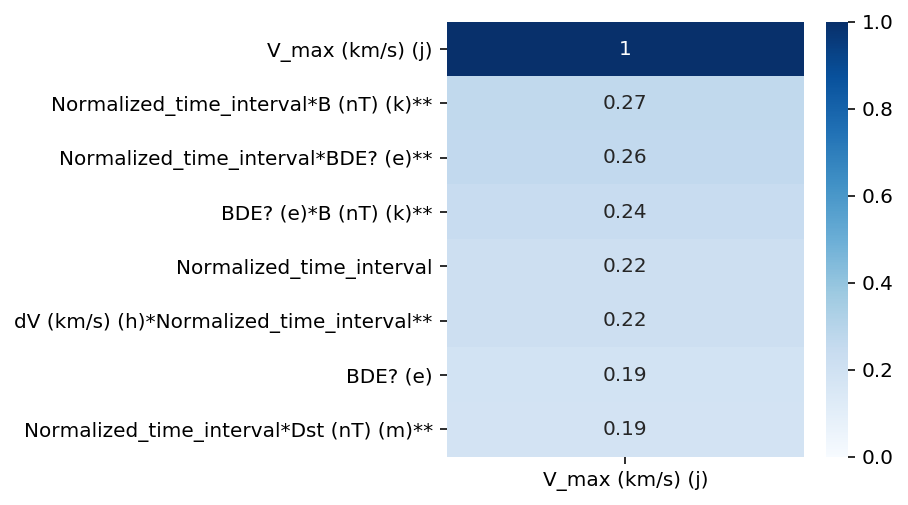

In [43]:
df_corr = df_new_2.corr().abs()
plt.figure(figsize=(4,4))
sns.heatmap(df_corr[['V_max (km/s) (j)']].sort_values(by=['V_max (km/s) (j)'],ascending=False),
            vmin=0,
            cmap='Blues',
            annot=True);
plt.savefig("../Figures/" + section_fig_main_title +"corr_3.png")
plt.show()

In [45]:
df_new_2.columns

Index(['ICME Plasma/Field Start Y/M/D (UT) (b)',
       'ICME Plasma/Field End Y/M/D (UT) (b)', 'V_max (km/s) (j)',
       'Normalized_time_interval*B (nT) (k)**',
       'Normalized_time_interval*BDE? (e)**', 'BDE? (e)*B (nT) (k)**',
       'Normalized_time_interval', 'dV (km/s) (h)*Normalized_time_interval**',
       'BDE? (e)', 'Normalized_time_interval*Dst (nT) (m)**'],
      dtype='object')

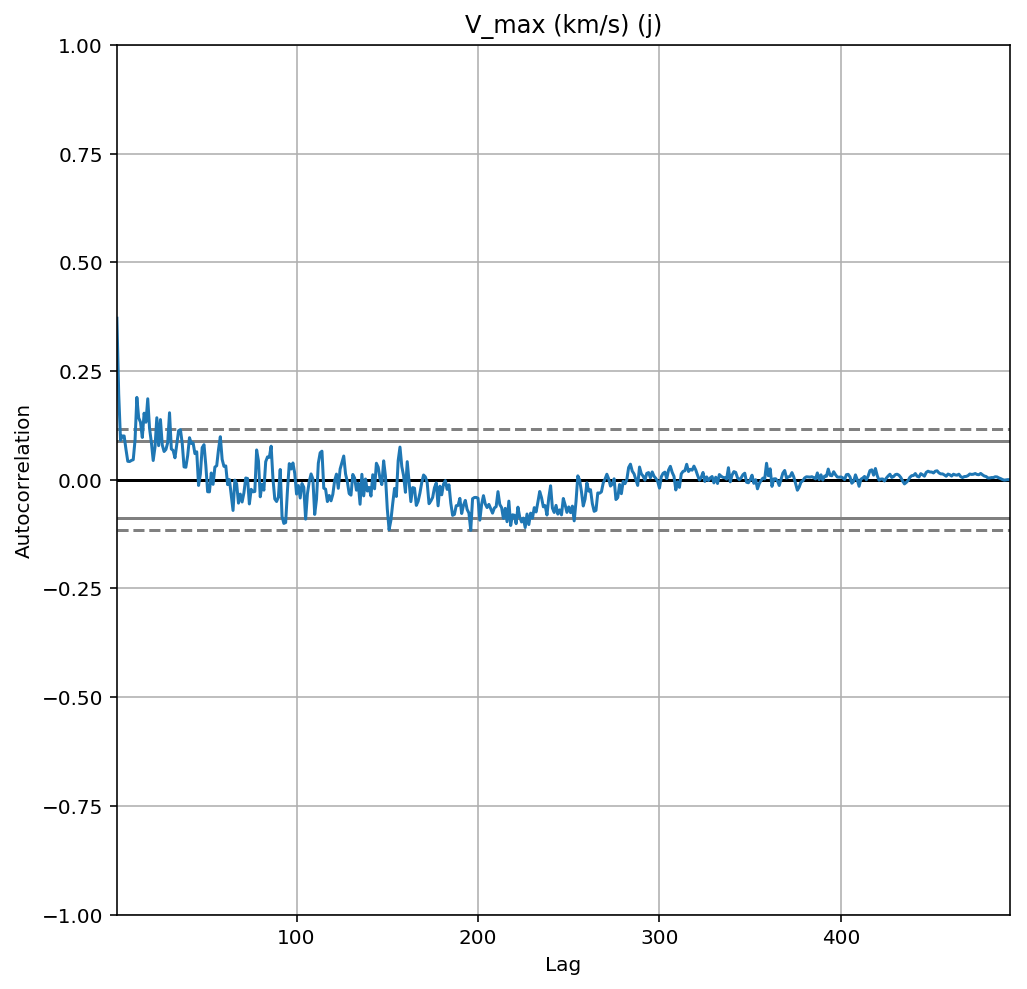

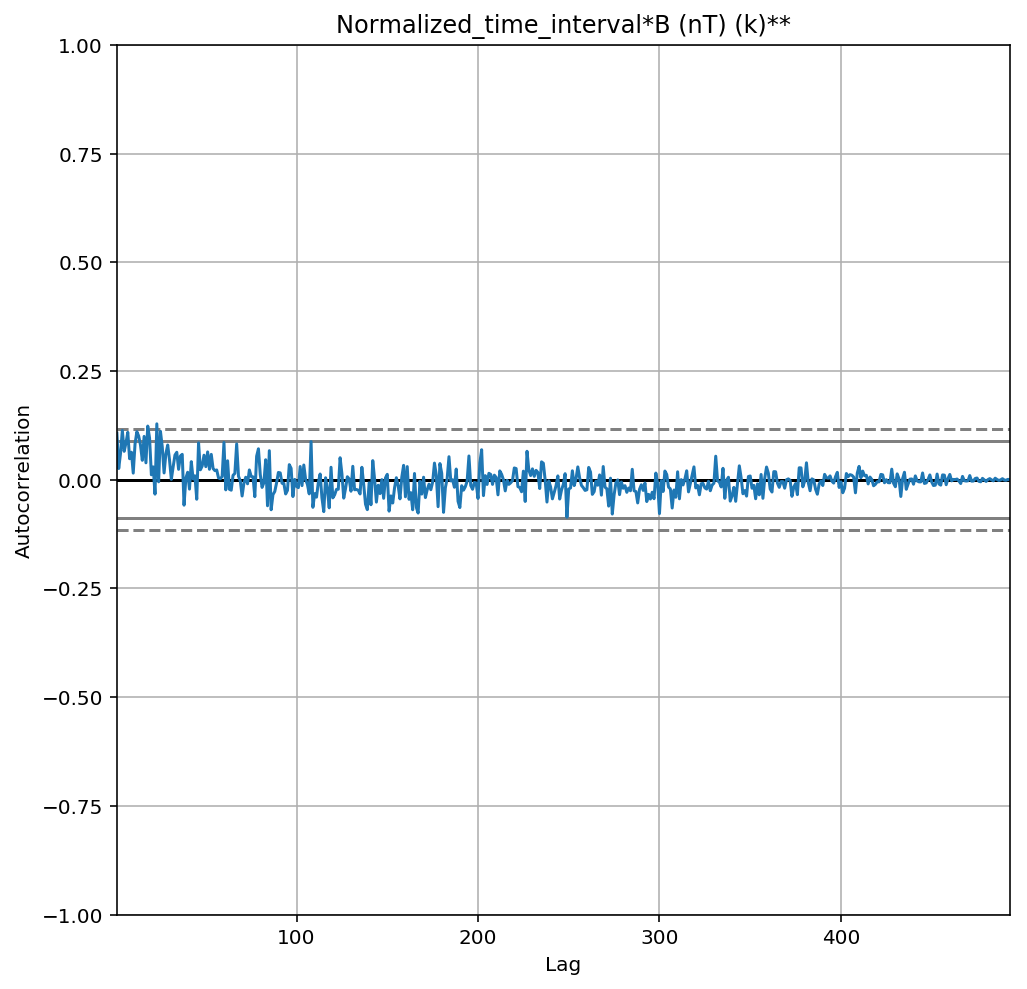

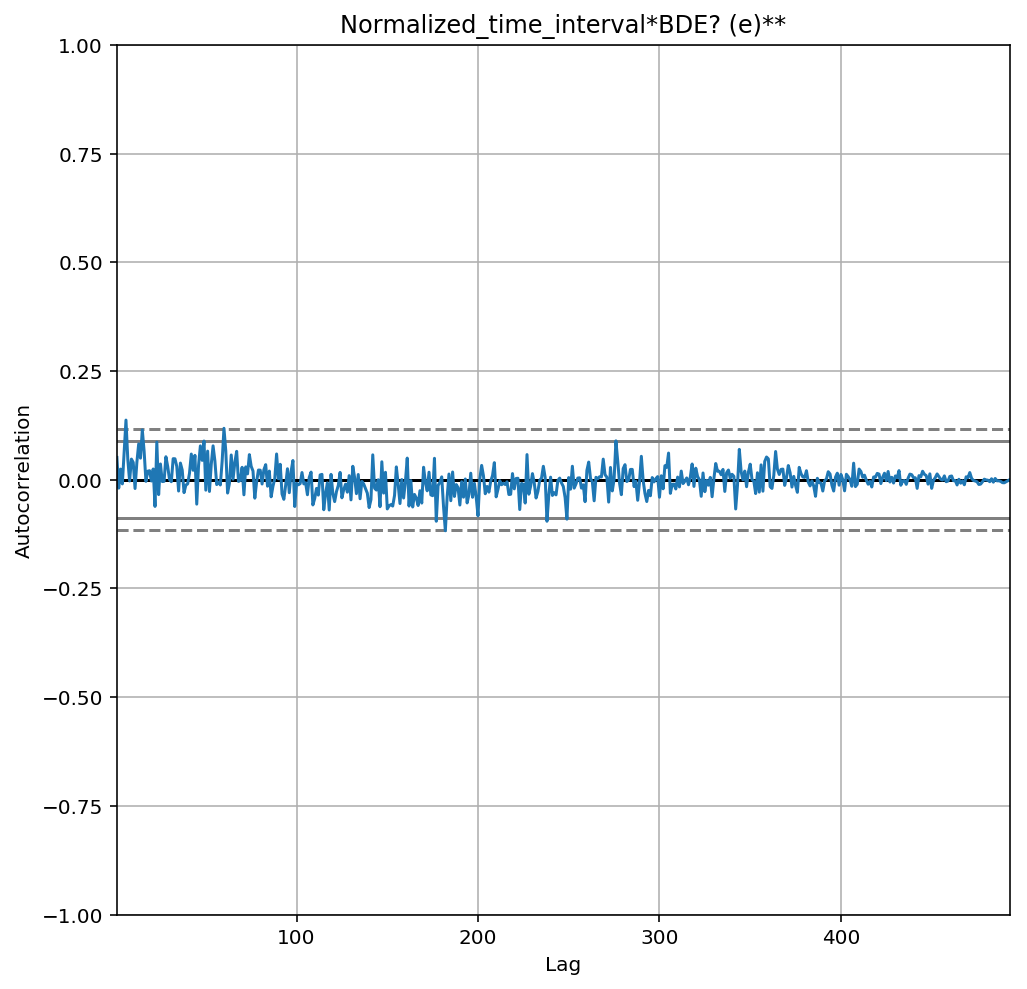

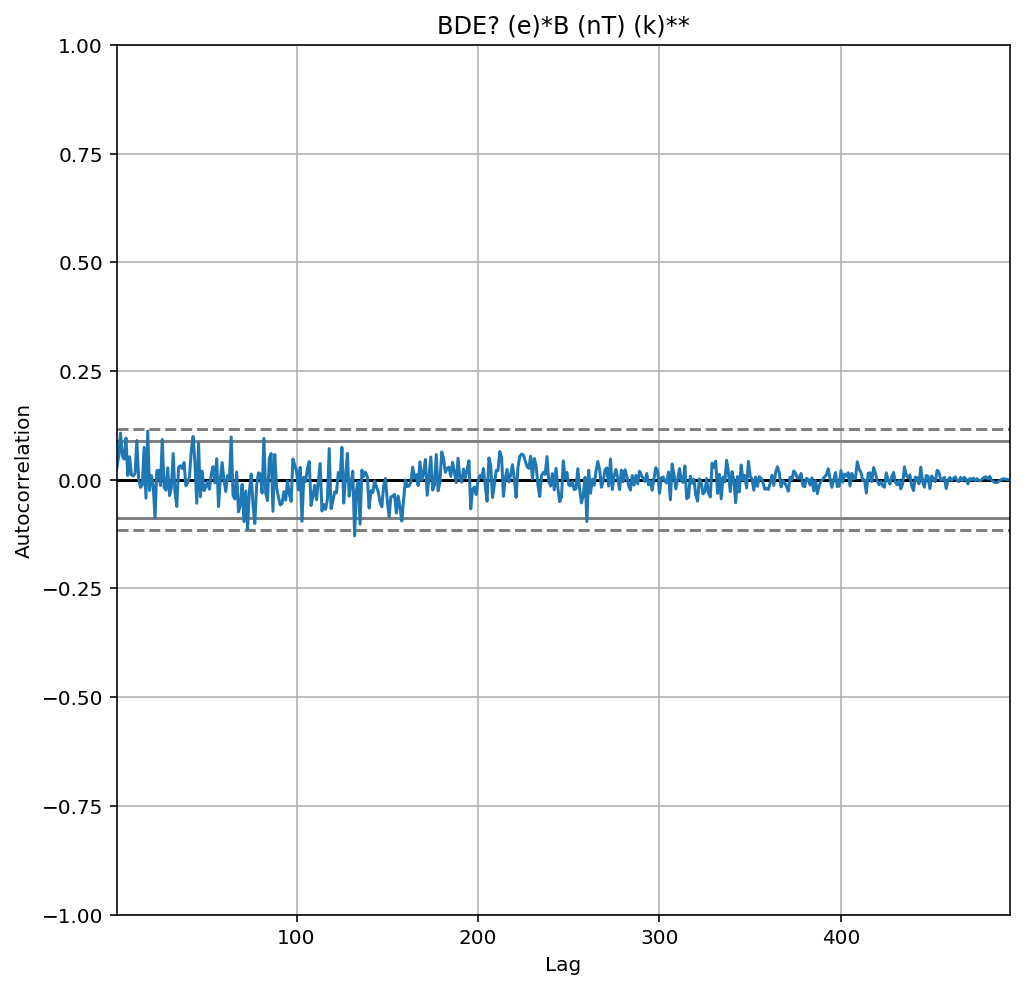

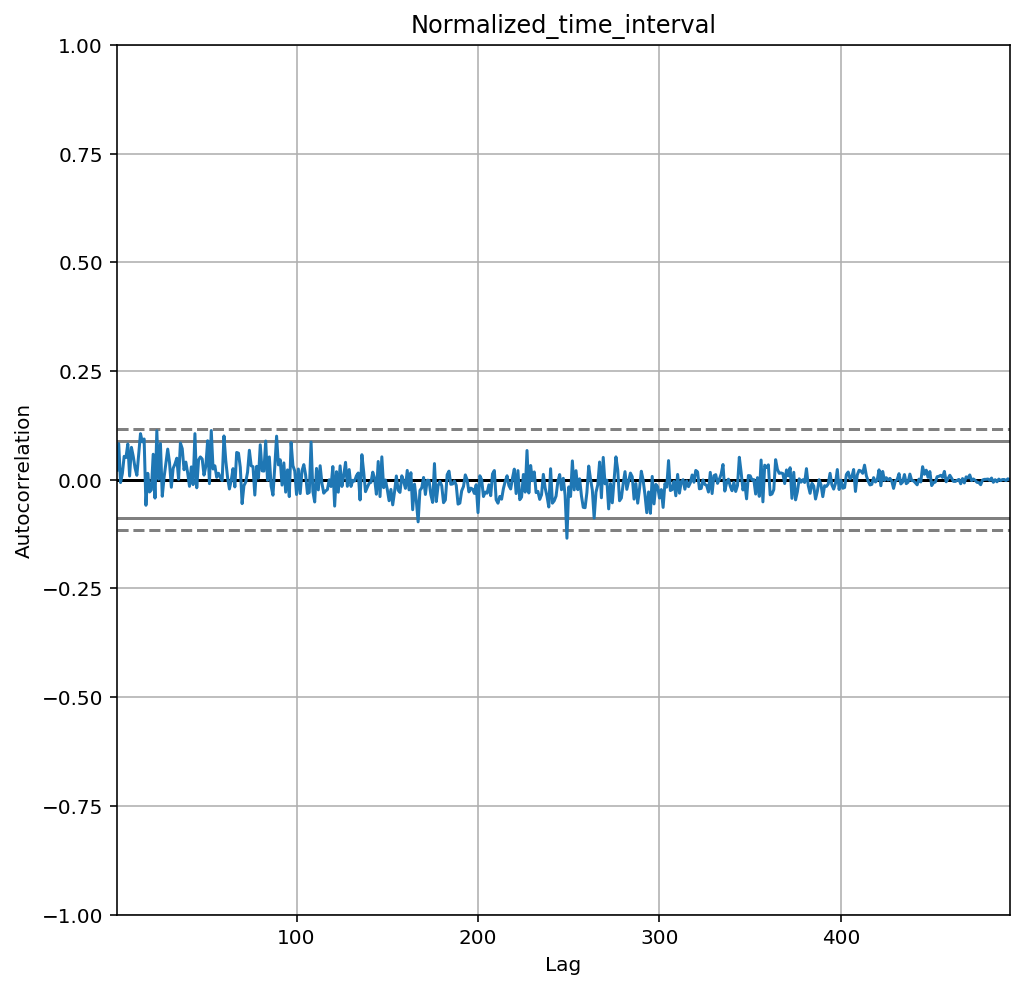

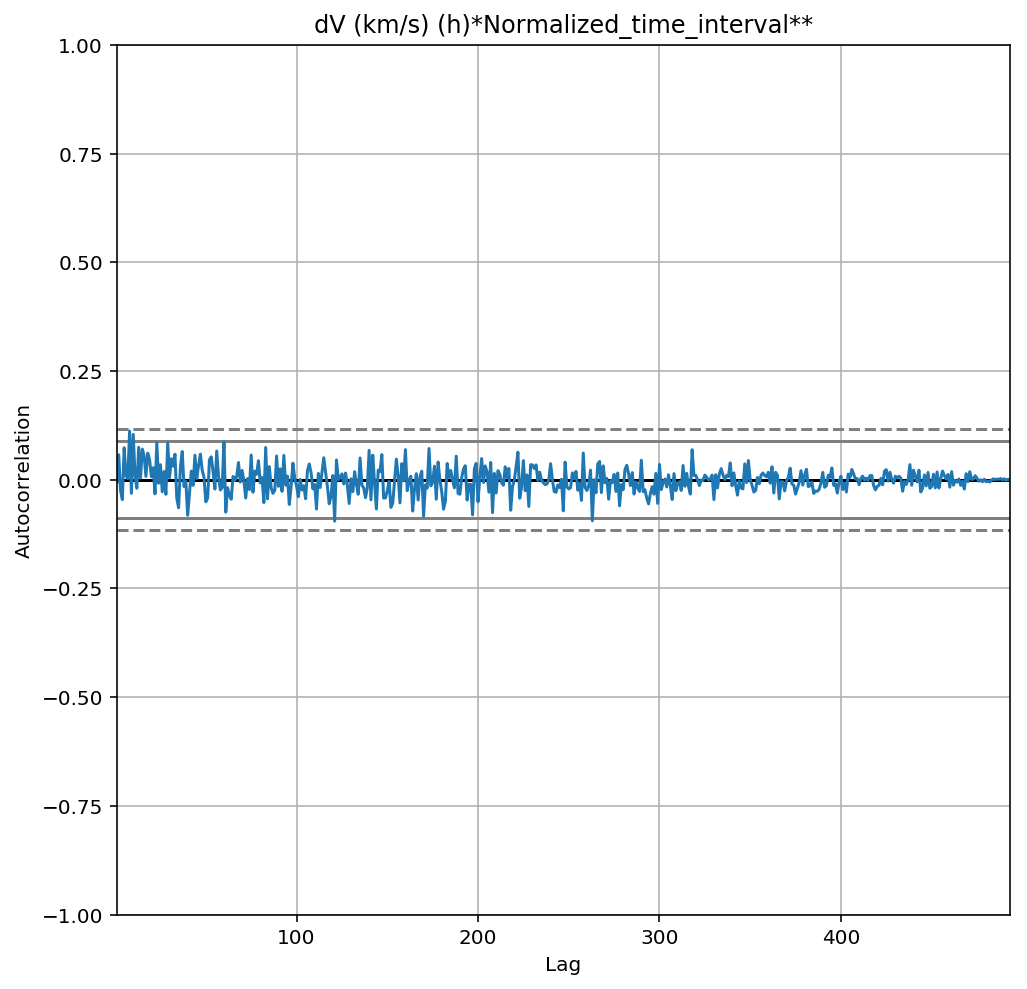

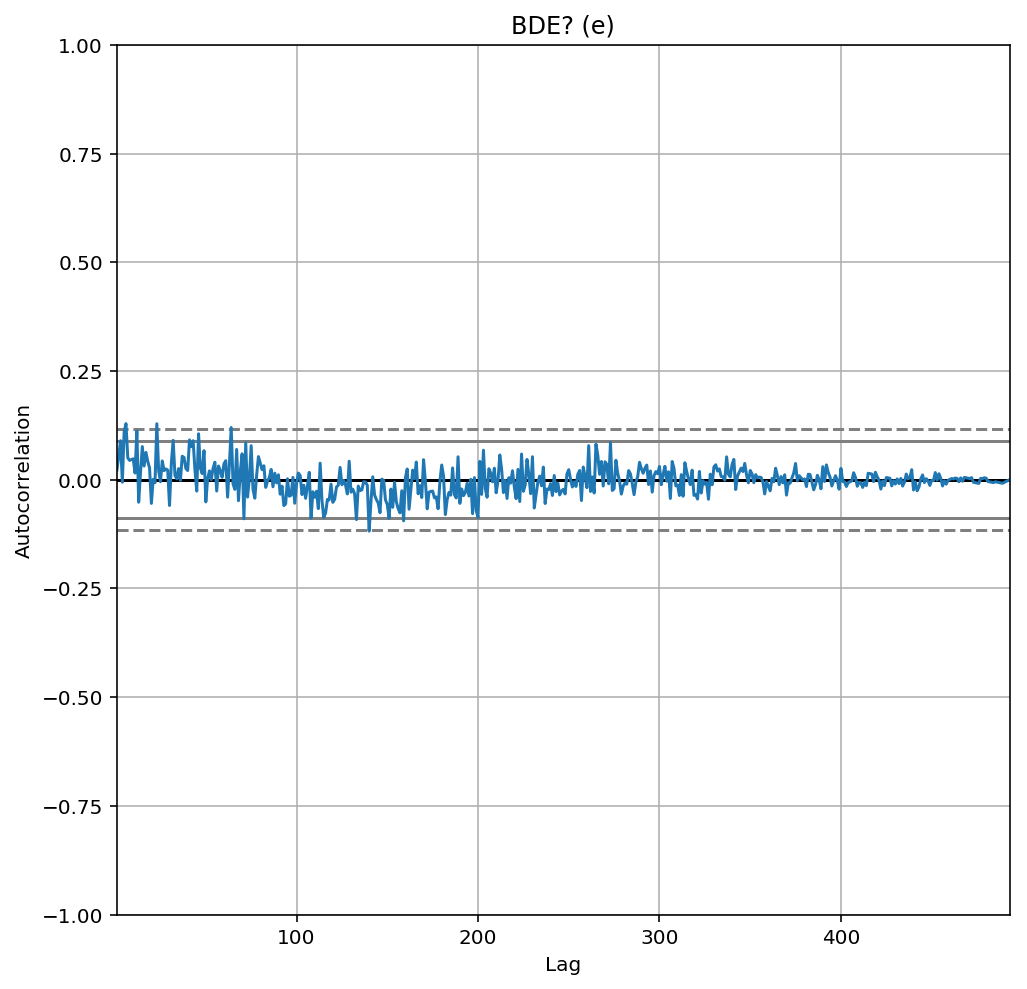

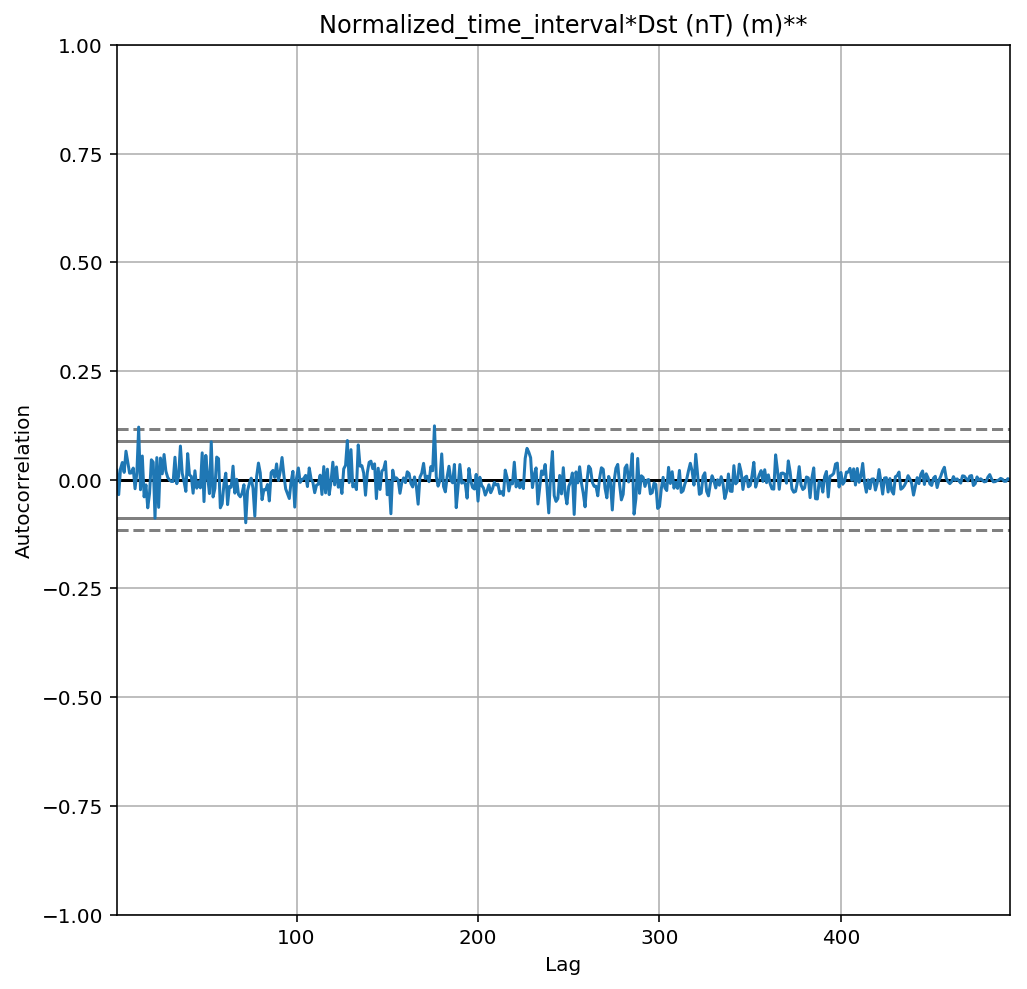

In [60]:
# plt.figure(figsize=(14,10))

for i, col in enumerate(df_new_2.columns):
    if col == 'ICME Plasma/Field Start Y/M/D (UT) (b)' or col == 'ICME Plasma/Field End Y/M/D (UT) (b)':
        pass
    else:
#         plt.subplot(3,3,i)
#         print(col)
        autocorrelation_plot(df_new_2[col])
        plt.title(col)
        # plt.savefig("../Figures/" + section_fig_main_title +"autocorr_plt_1.png")

    plt.show()

No correlation is observed.

In [61]:
X = df[['Normalized_time_interval*B (nT) (k)**',
        'Normalized_time_interval*BDE? (e)**', 'BDE? (e)*B (nT) (k)**',
        'Normalized_time_interval', 'dV (km/s) (h)*Normalized_time_interval**',
        'BDE? (e)', 'Normalized_time_interval*Dst (nT) (m)**']]

y = df['V_max (km/s) (j)']

In [62]:
X_sm = sm.add_constant(X)
ols = sm.OLS(y, X_sm).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       V_max (km/s) (j)   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     9.755
Date:                Mon, 25 Oct 2021   Prob (F-statistic):           2.16e-11
Time:                        00:07:33   Log-Likelihood:                -3164.8
No. Observations:                 493   AIC:                             6346.
Df Residuals:                     485   BIC:                             6379.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                      431.0525     34.424     12.522      0.000     363.414     498.691
Normalized_time_interval*B (nT) (k)**       -4.6713      2.994     -1.560      0.119     -10.554       1.212
Normalized_time_interval*BDE? (e)**         15.0760     12.732      1.184      0.237      -9.940      40.092
BDE? (e)*B (nT) (k)**                        3.7840      1.060      3.571      0.000       1.702       5.866
Normalized_time_interval                    31.4483     37.900      0.830      0.407     -43.020     105.917
dV (km/s) (h)*Normalized_time_interval**     0.5697      0.305      1.870      0.062      -0.029       1.168
BDE? (e)                                   -24.0076     19.006     -1.263      0.207     -61.352      13.337
Normalized_time_interval*Dst (nT) (m)**      0.1543      0.097      1.596      0.111      -0.036       0.344
==============================================================================
Omnibus:                      310.163   Durbin-Watson:                   1.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4404.831
Skew:                           2.489   Prob(JB):                         0.00
Kurtosis:                      16.772   Cond. No.                     1.09e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

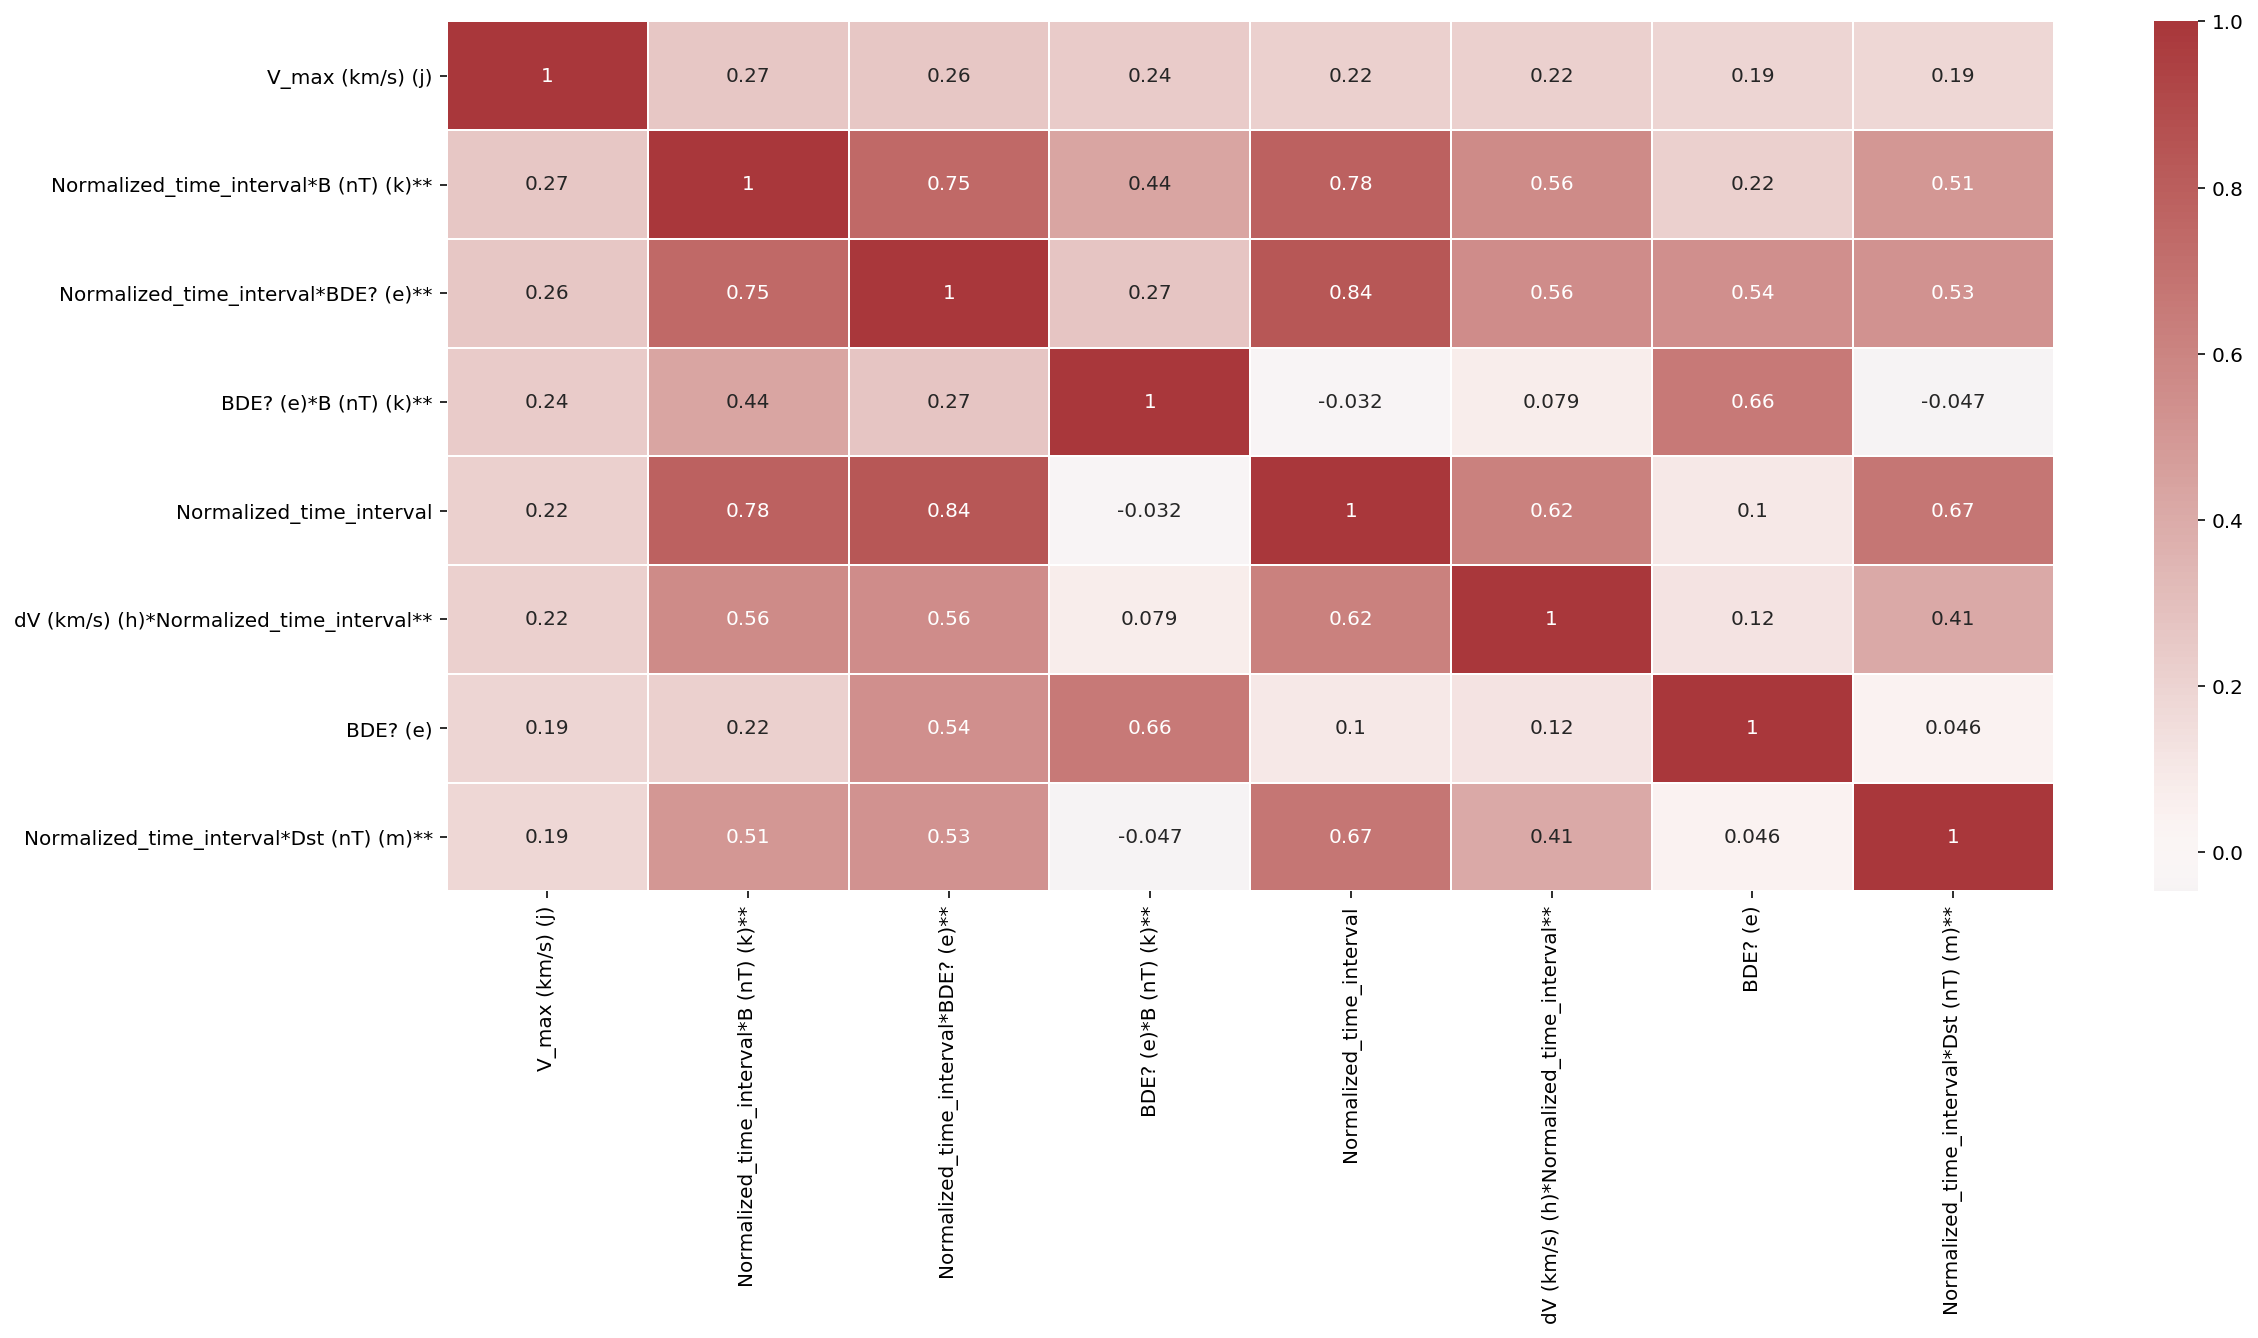

In [64]:
df_corr = df_new_2.corr()
plt.figure(figsize=(18,8))

sns.heatmap(df_corr, 
            xticklabels=df_corr.columns,
            yticklabels=df_corr.columns,
            cmap='vlag',
            annot=True,
            linewidth=0.5, center=0,
#             vmin=-0.2, vmax=0.3
           )
# plt.savefig("../Figures/" + section_fig_main_title +"corr_2.png")

strong multicollinearity is observed. 

I am not sure that engineering new features are helpful due to introducing new features with strong covariance.

The new features may or may not help the ML algorithms. The only way is to save two data frames and apply ML algorithms and check out the results.

In [65]:
file_path = "../Data/"
file_name = "Data_ICME_Engineered_P02_04.csv"
df_new_2.to_csv(file_path+file_name, index=False)